In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import pickle
from datetime import datetime
from pickle import dump
import mlflow
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
np.random.seed(40)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

In [3]:
prediction_df = pd.read_csv('../data/prediction_df.csv')
print(len(prediction_df))
prediction_df.head()

1017209


,Open,DayOfWeek,Promo,Sales
0,1,5,1,5263.0
1,1,5,1,6064.0
2,1,5,1,8314.0
3,1,5,1,13995.0
4,1,5,1,4822.0


In [5]:
## separate the independent and target variable 
X = prediction_df.drop(['Sales'], axis = 1)
y = prediction_df['Sales']

In [6]:
# Splitting our dataset into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print ("Training and testing split was successful.")

Training and testing split was successful.


In [7]:
# Define the Pipeline
model_pipeline = Pipeline(steps=[('random_forest', RandomForestRegressor(max_depth=10,random_state=2))])

In [8]:
model = RandomForestRegressor()

In [9]:
print(X.shape, y.shape)

(1017209, 3) (1017209,)


In [10]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [11]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              min_samples_leaf=10000)

In [12]:
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10000, n_jobs=-1, random_state=42)

In [13]:
show_scores(model)

{'Training MAE': 1449.1721339881271,
 'Valid MAE': 1451.615159151369,
 'Training RMSLE': 0.3302230275252372,
 'Valid RMSLE': 0.3262472218045086,
 'Training R^2': 0.6314854897269508,
 'Valid R^2': 0.6331816604953748}

In [16]:
%%time

# Most ideal hyperparamters
ideal_model1 = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model1.fit(X_train, y_train)

CPU times: total: 14.2 s
Wall time: 6.79 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [17]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model1)

{'Training MAE': 1449.207249602697,
 'Valid MAE': 1451.7182673158195,
 'Training RMSLE': 0.33025449564072457,
 'Valid RMSLE': 0.3262808761918615,
 'Training R^2': 0.6315744600725388,
 'Valid R^2': 0.6332441436675471}

In [18]:
# saving the model 
import pickle 
pickle_out = open("ideal_model1.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [19]:
ideal_model1.feature_importances_

array([0.45336492, 0.38098032, 0.16565477])

In [20]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

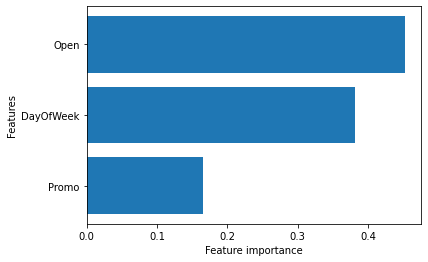

In [21]:
plot_features(X_train.columns, ideal_model1.feature_importances_)